In [27]:
from PreLoader import PreLoader
import ArrayGenerator
import numpy as np
import pandas as pd
from collections import Counter

In [48]:
# Initialize a preloader object with the range required
preloader = PreLoader("vhr") # Pass "vlr" or "vhr" or "both".

In [49]:
# To take a look at the dataframe
preloader.df.head()

,name,date,status,rpm,bearing_abbs,standardized_faults,report_name,zone,area,factory,type,ts_shape_no_nans
0,Main Fan A(F-005A),2022-01-20,hmv,1476.6,{},"[Misalignment,machine, SoftFoot,motor, BasePro...",RTC220055-9004934-Line 4-F-005A-V001-D-36-3101...,AZFC Zone 4,New Numan Mill,AZFC,vhr,"(12, 8192)"
1,Main Fan A(F-005A),2022-05-16,hmv,1488.0,{},"[Misalignment,machine, SoftFoot,motor, BasePro...",RTC220340-Line 4-F-005A-V001-D-36-2205-22-6527...,AZFC Zone 4,New Numan Mill,AZFC,vhr,"(12, 8192)"
2,Main Fan A(F-005A),2022-06-19,hmv,1486.2,{},"[Misalignment,machine, SoftFoot,motor, BasePro...",RTC220449-9008483-Line 4-F-005A-V001-D-36-0307...,AZFC Zone 4,New Numan Mill,AZFC,vhr,"(12, 8192)"
3,Main Fan A(F-005A),2021-01-21,l3,1496.0,{},"[BearingLubrication,motor, Misalignment,machin...",RTC210051-Line 4-F-005A-V001-D-36-2501-21-3834...,AZFC Zone 4,New Numan Mill,AZFC,vhr,"(12, 8192)"
4,Main Fan A(F-005A),2021-11-25,l3,1476.6,{},"[Misalignment,machine, SoftFoot,motor, BasePro...",RTC210702-Line 4-F-005A-V001-D-36-0212-21-5945...,AZFC Zone 4,New Numan Mill,AZFC,vhr,"(12, 8192)"


In [50]:
# Get 3D time series array and its labels
ts_array = preloader.get_3d_ts_array()
labels = preloader.get_labels_array(labels_type="faults") # or use labels_type = "status" for classifying the status

In [51]:
ts_array.shape, labels.shape

((217, 12, 16384), (217,))

In [119]:
# Get a dataset cateogry, check the DatasetArrayGenerator.py file for explanation of the categories
X, y = ArrayGenerator.generate_dataset_array(dataset_category=2, ts=ts_array, labels=labels, split_method="bearing") # Split method can be channel, bearing, machine or None
X.shape, y.shape

{'Faults classified': 'BearingFault, BearingWear, BearingLubrication', 'Channels taken': 'According to label', 'Labels array': 'Binary'}


((868, 3, 16384), (868,))

In [120]:
# Widnowing data
# Define windowing parameters
window_size = 2048
overlap_pct = 0.1
with_fft = False

X_windowed, y_windowed = ArrayGenerator.apply_sliding_window(ts_3d=X, labels=y, window_size=window_size, overlap_pct=overlap_pct, with_fft=with_fft)
X_windowed.shape, y_windowed.shape

((4248, 3, 2048), (4248,))

In [124]:
# Proceed with our modelling as before

In [125]:
from tsai.all import *
computer_setup()

f:\Anaconda\envs\ML\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


os              : Windows-10-10.0.19045-SP0
python          : 3.8.18
tsai            : 0.3.8
fastai          : 2.7.13
fastcore        : 1.5.29
torch           : 2.1.2
device          : 1 gpu (['NVIDIA GeForce GTX 1650 Ti'])
cpu cores       : 6
threads per cpu : 2
RAM             : 15.87 GB
GPU memory      : [4.0] GB


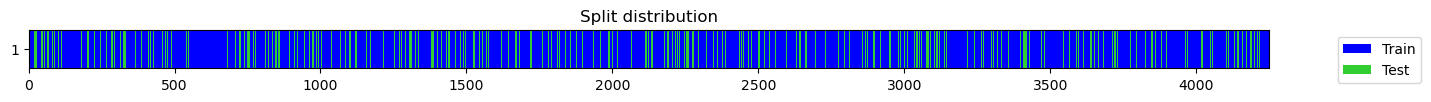

((#4180) [2926,572,406,3887,1670,1187,2927,2743,1087,2097...],
 (#849) [1074,2844,2558,1335,1166,2930,1772,2666,766,2137...])

In [126]:
splits = get_splits(y_windowed, valid_size=0.2, random_state=23, shuffle=True, balance=True)
splits

In [128]:
tfms  = [None, [TSStandardize(by_var=True), Categorize()]]
batch_tfms = [TSStandardize(by_sample=True)]
dls = get_ts_dls(X_windowed, y_windowed, splits=splits, tfms=tfms, shuffle_train=True, batch_tfms=batch_tfms, bs=[64,256])

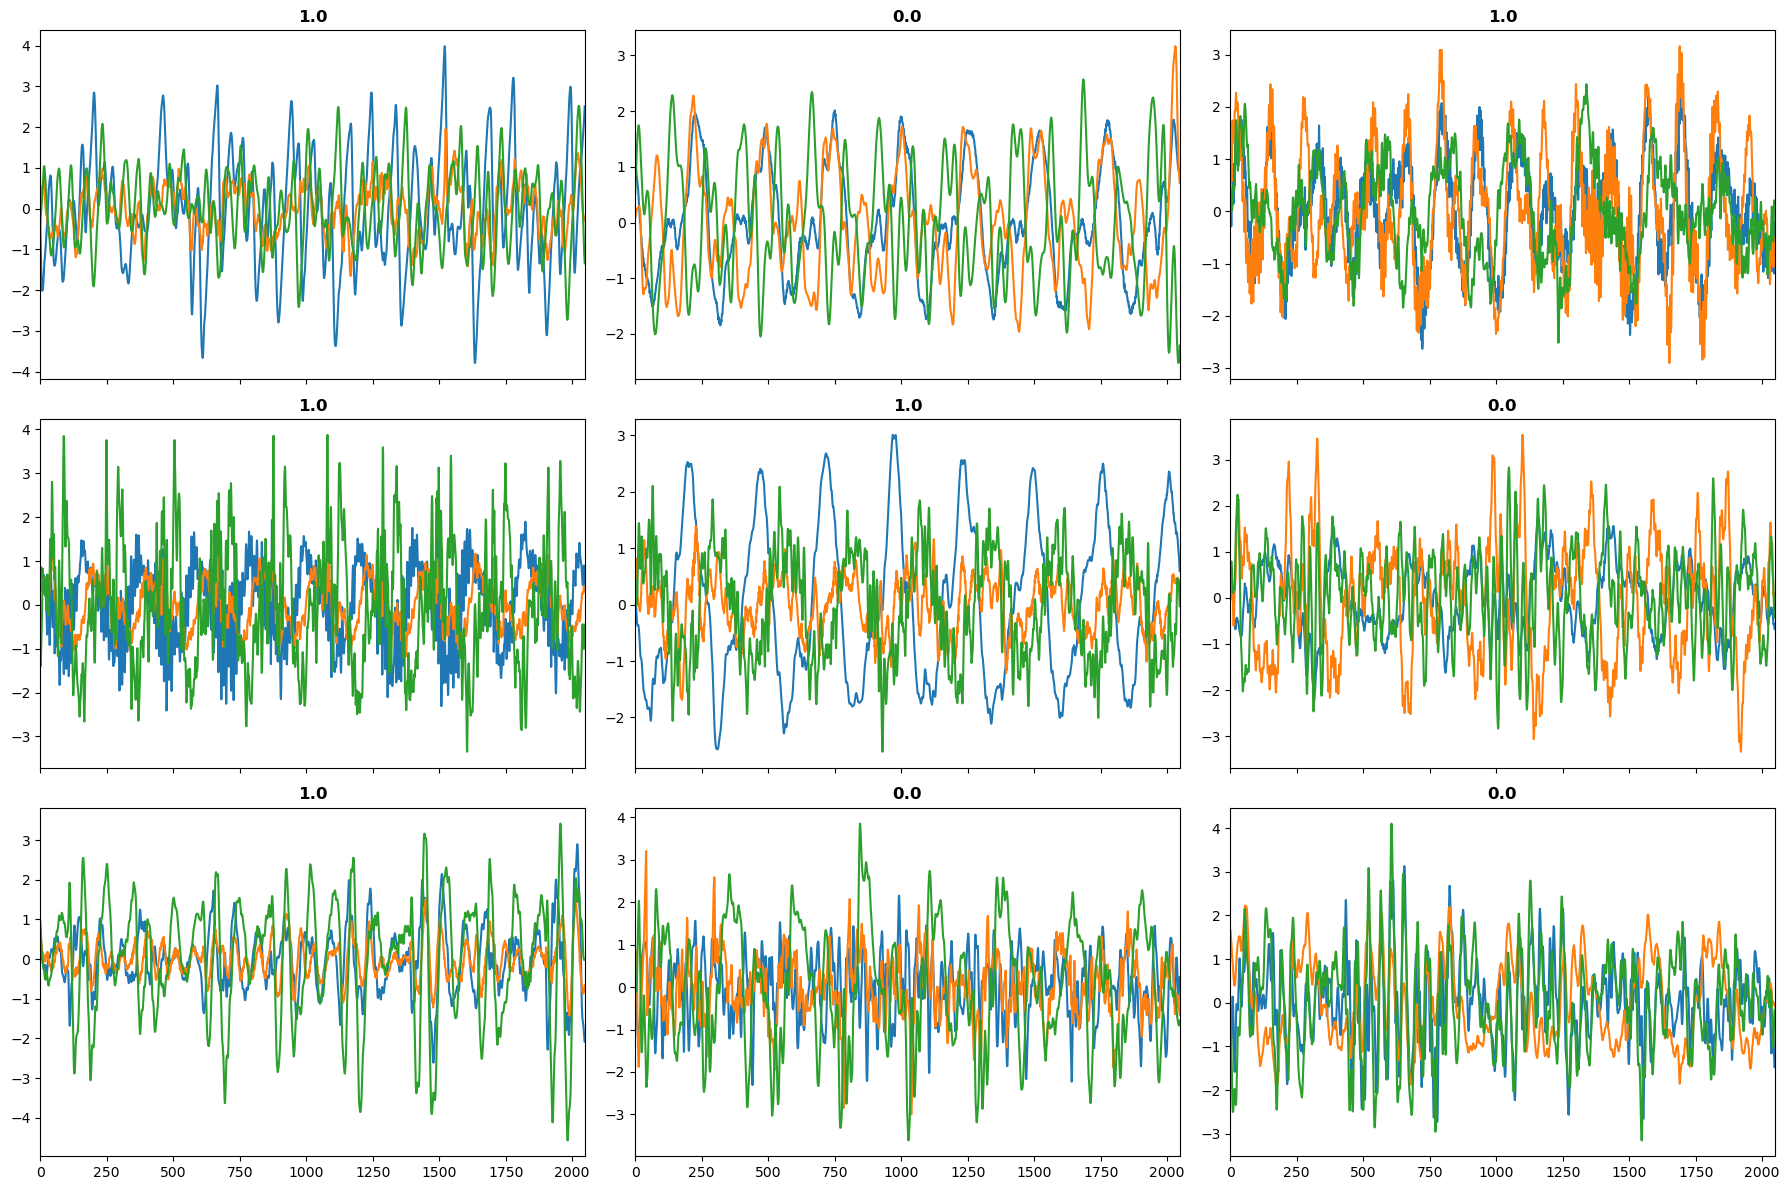

In [129]:
dls.show_batch(sharex=True)

In [130]:
model = InceptionTime(dls.vars, dls.c)
learn = Learner(dls, model, metrics=[accuracy, Precision(), Recall(), F1Score()])

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.623778,0.620818,0.658422,0.540659,0.752294,0.629156,00:18
1,0.572926,0.702589,0.575972,0.473430,0.899083,0.620253,00:17
2,0.530994,0.777745,0.594817,0.486614,0.944954,0.642412,00:17
3,0.494681,0.647247,0.641932,0.520871,0.877676,0.653759,00:18
4,0.441753,0.590906,0.707892,0.577603,0.899083,0.703349,00:18
5,0.400027,0.414170,0.809187,0.811321,0.657492,0.726351,00:18
6,0.355263,0.389004,0.835100,0.766382,0.822630,0.793510,00:19
7,0.297601,0.307145,0.869258,0.877622,0.767584,0.818923,00:18
8,0.251618,0.392791,0.808009,0.955556,0.525994,0.678501,00:19
9,0.208422,0.257738,0.898704,0.892508,0.837920,0.864353,00:19


,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score
9,0.208422,0.257738,0.898704,0.892508,0.83792,0.864353


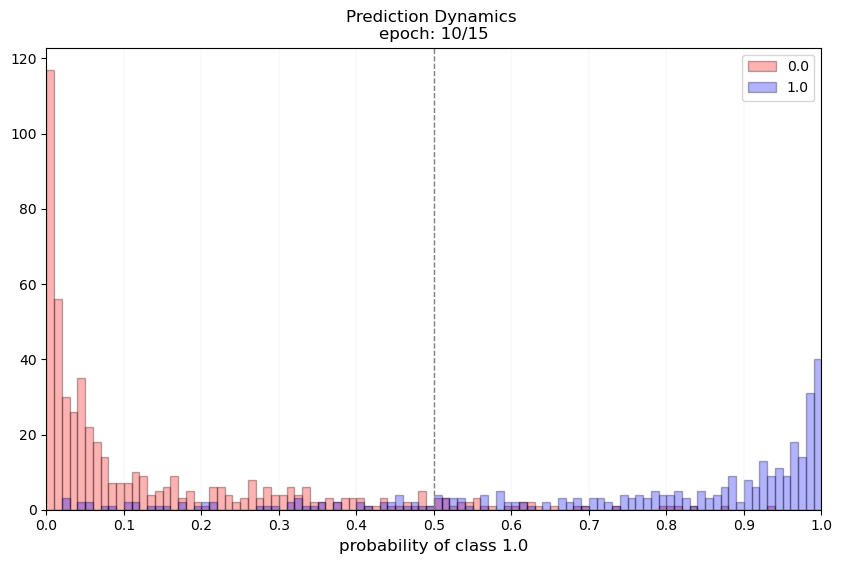

: 

In [131]:
learn.fit_one_cycle(15, lr_max=learn.lr_find(), cbs=[PredictionDynamics()])